In [1]:
import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import Utils.DiaSourceTools as DSTools
from astropy.time import Time

import lsst.afw.display.ds9 as ds9

import re

import lsst.daf.base as dafBase

import lsst.afw.math as afwMath

import glob
from astropy.io import ascii

from lsst.ip.diffim import ImagePsfMatchTask, DipoleMeasurementTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.deblender import SourceDeblendTask

from lsst.afw.fits import FitsError

from astropy.table import Column

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
DATADIR="/datadec/cppm/jpreyes/CFHT_Complete"
#DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_daytest/"

directory = DATADIR+"/detect_testSN_2/"
butler = dafPersist.Butler(directory) 


In [3]:
dayDiff = butler.get("dayDiff_differenceExp", dataId={"filter":'r',"tract":0, "patch":'15,15', 'date':'2004-04-22'})

In [4]:
image = dayDiff.getMaskedImage().getImage()

In [4]:
def get_threshold(dayDiff):
    mi = dayDiff.getMaskedImage()
    bad = dayDiff.getMaskedImage().getMask().getPlaneBitMask(['BAD', 'SAT', 'EDGE', 'NO_DATA', ])
    sctrl = afwMath.StatisticsControl()
    sctrl.setAndMask(bad)
    stats = afwMath.makeStatistics(mi, afwMath.STDEVCLIP, sctrl)
    thres = (stats.getValue(afwMath.STDEVCLIP) * 5)
    return thres

In [5]:
patches = []
patches_file=open(DATADIR+"/patches.txt", "rb")
for line in patches_file:
    line = line.replace('\n','')
    text = re.split("=| ",line)
    patches.append(text[-1])
patches_file.close()


In [6]:
diffexps = []

for patch in patches: 
    if butler.datasetExists("dayDiff_differenceExp", dataId={"filter":'r',"tract":0, "patch":patch, 'date':'2004-04-22'}):
        diffexps.append(butler.get("dayDiff_differenceExp", dataId={"filter":'r',"tract":0, "patch":patch, 'date':'2004-04-22'}))

In [56]:
diff = []
for dexp in diffexps:
    t1 = get_threshold(dexp)
    array = dexp.getMaskedImage().getImage().getArray().flatten()
    non_nan = np.isnan(array)
    array[non_nan] = 0
    bad_flags = dexp.getMaskedImage().getMask().getPlaneBitMask(['BAD', 'SAT', 'EDGE', 'NO_DATA', ])
    mask =  dexp.getMaskedImage().getMask().getArray().flatten()
    marray = mask.copy()
    marray = np.array(marray)
    marray = marray[marray&bad_flags != 0]
    #marray[mask.flatten()&bad_flags!=0]=0
    t2 = np.std(marray)*5

    diff.append(t1-t2)


In [57]:
print len(mask), len(marray)


1440000 1015467


In [47]:
test = np.array(array.copy())

test=[1,2,3,4,5,6,7,8,9, 275]
test = np.array(test)
test[test&bad_flags!=0]
print test, bad_flags


[  1   2   3   4   5   6   7   8   9 275] 275


In [48]:
test

array([  1,   2,   3,   4,   5,   6,   7,   8,   9, 275])

In [34]:
t = test[test&bad_flags==0]
print t

[4 8]


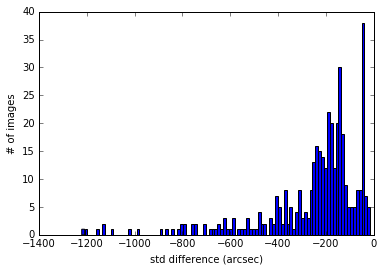

In [60]:
plt.hist(diff, bins=100)
plt.xlabel("std difference (arcsec)")
plt.ylabel("# of images")
plt.show()

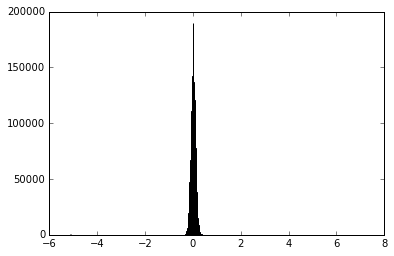

In [20]:
plt.hist(array.flatten(), bins=500)
plt.show()

In [23]:
ds9.mtv(image, frame=1)

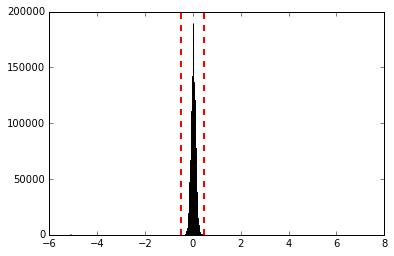

In [28]:
sigma_5 = array.std()*5
plt.hist(array.flatten(), bins=500)

plt.axvline(sigma_5, color='r', linestyle='dashed', linewidth=2)
plt.axvline(-sigma_5, color='r', linestyle='dashed', linewidth=2)
plt.show()

In [29]:
dayDiff.get